# A Look at Sentiment on the Kaggle Forums

This notebook uses:

 - [Meta Kaggle][3] dataset.
 - [Run HuggingFace Sentiment Analysis on Forum Posts][1] which computes Sentiment scores for all the Kaggle forum posts using the [HuggingFace Sentiment Analysis Pipeline][2], and saves the results.

Here, we take a look at those results!

## Bottom Line Up Front

Looking at the results of the classifier: the highest positivity scores have been assigned to "short but sweet" compliment-type messages.
Highly critical complaints have correctly been given some of the most negative scores - but a lot of technical "tech support" type forum posts have also been scored as negative.


## Contents

 * [Rebase Scores](#Rebase-Scores)
 * [Kaggle Forum Sentiment Scores over Time](#Kaggle-Forum-Sentiment-Scores-over-Time)
 * [Read Forum Messages](#Read-Forum-Messages)
 * [Bumps in Score Distribution](#Bumps-in-Score-Distribution)
 * [Message Length vs Sentiment Score](#Message-Length-vs-Sentiment-Score)
 * [Top Messages: Most Positive](#Top-Messages:-Most-Positive)
 * [Top Messages: Most Negative](#Top-Messages:-Most-Negative)
 * [Save Messages](#Save-Messages)
 * [Sentiment Sum over Time](#Sentiment-Sum-over-Time)
 * [Mean Sentiment over Time](#Mean-Sentiment-over-Time)
 * [Days of Peak Sentiment](#Days-of-Peak-Sentiment)
 * [Sentiment of Most Active Posters](#Sentiment-of-Most-Active-Posters)
 * [Sentiment of Least Active Posters](#Sentiment-of-Least-Active-Posters)
 * [Sentiment and Rewards: Medals](#Sentiment-and-Rewards:-Medals)
 * [Sentiment of Discussion Masters](#Sentiment-of-Discussion-Masters)
 * [Sentiment and Day of Week](#Sentiment-and-Day-of-Week)
 * [Sentiment and Hour of Day](#Sentiment-and-Hour-of-Day)
 * [Sentiment and Day](#Sentiment-and-Day)
 * [Sentiment Heatmap by Hour](#Sentiment-Heatmap-by-Hour)
 * [Sentiment by Forum Title](#Sentiment-by-Forum-Title)
 * [Mean Sentiment for Top Notebooks](#Mean-Sentiment-for-Top-Notebooks)
 * [Conclusions](#Conclusions)

 [1]: https://www.kaggle.com/jtrotman/run-huggingface-sentiment-analysis-on-forum-posts
 [2]: https://huggingface.co/transformers/main_classes/pipelines.html
 [3]: https://www.kaggle.com/kaggle/meta-kaggle

In [1]:
from jt_mk_utils import *

In [2]:
import gc, os, sys, re, time
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, Image, display
import seaborn as sns
import plotly.express as px

In [3]:
# Thanks to Sam Stoltenberg: https://skelouse.github.io/styling_a_jupyter_notebook
display(HTML("""<style>.container { max-width:100% !important; }
.output_result { max-width:100% !important; }
.output_area { max-width:100% !important; }
.input_area { max-width:100% !important; }
h1 {
  border: 3px solid #333;
  padding: 8px 12px;
  background-image: linear-gradient(180deg, rgb(160, 147, 147), #fff);
  position: static;
}
</style>"""))

plt.rcParams["figure.figsize"] = (11, 6)
plt.rcParams["figure.facecolor"] = "#FFFACD"
plt.rcParams["axes.facecolor"] = "#FFFFE0"
plt.rcParams["font.size"] = 13
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = "--"

HOST = "https://www.kaggle.com"

In [4]:
SENTIMENT_CSV = '../input/run-huggingface-sentiment-analysis-on-forum-posts/forum-messages-sentiment-analysis.csv'
df = pd.read_csv(SENTIMENT_CSV, index_col=0)

In [5]:
df['score'].hist(bins=44)
plt.title('Raw Sentiment Scores');

In [6]:
df.groupby('label').score.agg(['count', 'min', 'mean', 'max', 'std'])

# Rebase Scores

Above we see the classifier assigns scores from 0.5 to 1.0 with a POSITIVE or NEGATIVE label.
Let's rebase that into one dimension: -1 will be negative and +1 positive.

In [7]:
df['score'] = ((df['score'] * 2) - 1) * np.where(df.label.str[0] == 'P', 1, -1)

In [8]:
df['score'].hist(bins=44)
plt.title('Rebased Sentiment Scores');

# Kaggle Forum Sentiment Scores over Time

Before we even load the forum messages we can look at the raw sentiment scores compared to message IDs.

In [9]:
df.reset_index().plot.scatter('Id', 'score', alpha=0.01, s=1)
plt.title('Kaggle Forum Sentiment Scores over Time');

The plot above is not very interesting, the scores are too tightly bunched together to see patterns.

So I tried a rank:rank plot instead.
When I ran this next cell in a Jupyter on my own computer I get this result:

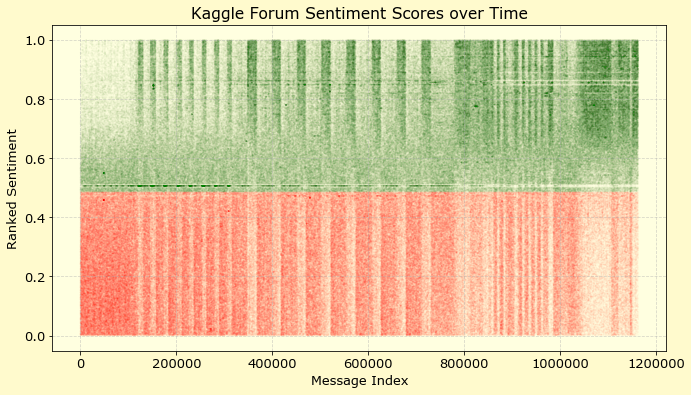

This was so exciting to see!

Could this be the natural waves of competitions over time?
There do not look to be enough cycles for that…

I was going to dig into this and investigate what causes this strange switching over time.
However, when I run it on Kaggle, for some reason, the pattern largely disappears!

In [10]:
plt.scatter(np.arange(len(df)), df['score'].rank(pct=True),
            alpha=0.01, s=1, c=np.where(df.label.str[0] == 'P', 'g', 'r'))
plt.xlabel('Message Index')
plt.ylabel('Ranked Sentiment')
plt.title('Kaggle Forum Sentiment Scores over Time');

To be investigated further...

# Read Forum Messages


In [11]:
forum_messages = read_forum_messages().set_index("Id")
forum_messages.shape

In [12]:
forum_messages = forum_messages.join(df, how='inner')
forum_messages = forum_messages.sort_index()
forum_messages = forum_messages.dropna(subset=['Message'])
forum_messages.shape

In [13]:
forum_topics = read_forum_topics(index_col=0)
forums = read_forums(index_col=0)
forum_messages = forum_messages.join(forum_topics[['ForumId', 'KernelId']],
                                     on='ForumTopicId',
                                     how='inner')
forum_messages = forum_messages.join(forums, on='ForumId', how='inner')
forum_messages.shape

In [14]:
SHOW_COLS = [
    'PostDate',
    'score',
    'Message',
]

# Bumps in Score Distribution

First thing I want to know is: what causes the peaks, especially around 0.5 and -0.4?

In [15]:
vc = forum_messages.score.value_counts()
vc.head(10).to_frame("Count")

In [16]:
score = vc.index[0]
score

### 0.9997161626815796 = Thank you!

& similar

In [17]:
top = forum_messages.query('score==@score').Message.value_counts()
top.to_frame("Count").head(20).style

In [18]:
# forum_messages.query('score==@score')[SHOW_COLS].sample(n=30, random_state=42).style

In [19]:
score = vc[vc.index<0.5].index[0]
score

### 0.496242880821228 = empty message

These are empty, or contain only:
 - an image
 - text in &lt;code&gt; tags
 - quoted text
 
which my html preprocessing removed.

In [20]:
forum_messages.query('score==@score')[SHOW_COLS].sample(n=30, random_state=42).style

In [21]:
score = vc[vc.index<0].index[0]
score

### -0.39411306381225586 = all unicode emojis - some with a word?

This looks unexpected, most appear positive - probably an issue with the way they were tokenized.

In [22]:
forum_messages.query('score==@score')[SHOW_COLS].sample(n=30, random_state=42).style.hide_index()

# Message Length vs Sentiment Score

In [23]:
plt.scatter(np.log1p(forum_messages.Message.str.len()), forum_messages.score, s=1, alpha=0.01)
plt.title('Log Message Length vs Sentiment Score');

There is clearly a bias here that shorter messages tend to be positive and longer messages are *scored* as negative, but perhaps the input truncation has affected that - bear that in mind for the rest of the notebook!

In [24]:
plt.scatter(forum_messages.Message.str.len().rank(pct=True),
            forum_messages['score'].rank(pct=True),
            alpha=0.01, s=1, c=np.where(forum_messages.label.str[0] == 'P', 'g', 'r'))
plt.title('Rank Message Length vs Rank Sentiment Score');

# Top Messages: Most Positive

In [25]:
top = df.sort_values('score').tail(30).index
forum_messages[SHOW_COLS].reindex(top).style.hide_index()

# Top Messages: Most Negative

In [26]:
bot = df.sort_values('score').head(30).index
forum_messages[SHOW_COLS].reindex(bot).style.hide_index()

# Save Messages

The above selections are not really extensive enough to get an idea of what is scored positive/negative, so save a HTML report you can download from the output files for a closer look.

In [27]:
def df_to_html(df):
    return df.to_html(escape=False).replace(r'\n', '\n').replace(r'\r', '\r')

def save_html(filename, df):
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(df_to_html(df))

In [28]:
extract = forum_messages.sort_values('score', ascending=False).head(1000)
save_html('messages-by-sentiment-top.html', extract)

In [29]:
extract = forum_messages.iloc[forum_messages.score.abs().argsort()].head(1000)
extract = extract.sort_values('score', ascending=False)
save_html('messages-by-sentiment-middle.html', extract)

In [30]:
extract = forum_messages.sort_values('score', ascending=True).head(1000)
save_html('messages-by-sentiment-bottom.html', extract)

Messages with most positive sentiment result in much smaller file:

In [31]:
!ls -l *.html

The word "Kaggle" confuses the classifer?

In [32]:
!grep -i kaggle messages-by-sentiment-top.html | wc -l
!grep -i kaggle messages-by-sentiment-middle.html | wc -l
!grep -i kaggle messages-by-sentiment-bottom.html | wc -l

# Sentiment Sum over Time

Note this also shows the daily *volume* of messages over time has increased - what is the overall sentiment?

In [33]:
messages_subset = forum_messages
gb = messages_subset.groupby(messages_subset.PostDate.dt.date)
gb['score'].sum().sort_index().plot()
plt.plot(plt.xlim(), (0, 0), color='r', linestyle='--', alpha=.4)
plt.title('Sum of Kaggle Forum Sentiment score over Time');

# Mean Sentiment over Time

This is more meaningful: what is the mean sentiment over time?
It is increasingly positive!

**Note**: There's a hidden bias here: competitions that are currently active are not included in [Meta Kaggle](https://www.kaggle.com/kaggle/meta-kaggle).
So towards the end of the plot competition-forum messages are 'dying out': the messages are only coming from the general forums and "Kernels" forum (messages under notebooks).

In [34]:
gb['score'].mean().sort_index().plot()
plt.plot(plt.xlim(), (0, 0), color='r', linestyle='--', alpha=.4)
plt.title('Kaggle Forums - Sentiment Mean Score over Time');

In [35]:
gb['score'].mean().sort_index().rename('All').plot(alpha=.5)
messages_subset = forum_messages.dropna(subset=['KernelId'])
gb = messages_subset.groupby(messages_subset.PostDate.dt.date)
gb['score'].mean().sort_index().rename('Kernels').plot(alpha=.5)
plt.plot(plt.xlim(), (0, 0), color='r', linestyle='--', alpha=.4)
plt.title('Kaggle Forums - Sentiment Mean Score over Time')
plt.legend();

## Competition Forums Only

Competition forums have `ParentForumId` of 8, check that:

In [36]:
messages_subset = (forum_messages.query("ParentForumId==8")
                   .sort_values('PostDate')
                   .set_index('PostDate'))
stats = messages_subset.Title.value_counts().to_frame("Count")
print(stats.shape) # expect ~400 or so main (featured/research) competition titles
stats.head()

Volume is going up but overall rolling sentiment *sum* stays negative...

Note how the fact active competitions are not in the data is indicated at the end - it looks like the rolling ScoreSum is coming back to zero but it's mainly due to low volume: new messages in old competition forums.

In [37]:
messages_subset.assign(MessageCount=1)['MessageCount'].rolling('14d').sum().plot()
messages_subset['score'].rolling('14d').sum().rename('ScoreSum').plot()
plt.plot(plt.xlim(), (0, 0), color='r', linestyle='--', alpha=.4)
plt.title('Kaggle Competition Forums - Sentiment over Time')
plt.legend();

However mean sentiment in competition forums **is** drifting up :-)

In [38]:
messages_subset['score'].rolling('14d').mean().plot()
plt.plot(plt.xlim(), (0, 0), color='r', linestyle='--', alpha=.4)
plt.title('Kaggle Competition Forums - Sentiment Mean Score over Time');

## Main Forums Only

The magic number is <a href="https://en.wikipedia.org/wiki/Revolution_9">9</a>.

In [39]:
messages_subset = (forum_messages.query("ParentForumId==9")
                   .sort_values('PostDate')
                   .set_index('PostDate'))
messages_subset.Title.value_counts().to_frame("Count")

### Monthly Smoothing

Plotting rolling mean average of the mean sentiment of the forum - message volume is not shown.

**Getting Started** is generally most positive & **Product Feedback** generally least.

Can you see **Christmas cheer** in here ?!

In [40]:
for title, sub in messages_subset.groupby('Title'):
    sub.score.rolling('30d').mean().rename(title).plot(alpha=.5)
plt.plot(plt.xlim(), (0, 0), color='r', linestyle='--', alpha=.4)
plt.title('Main Kaggle Forums Sentiment score over Time')
plt.ylabel('Rolling mean - mean sentiment')
plt.legend();

### Yearly Smoothing - Long Run Trend

**Getting Started** and **General** have made it into net-positive sentiment territory! 

In [41]:
for title, sub in messages_subset.groupby('Title'):
    sub.score.rolling('365d').mean().rename(title).plot(alpha=.5)
plt.plot(plt.xlim(), (0, 0), color='r', linestyle='--', alpha=.4)
plt.title('Main Kaggle Forums Sentiment score over Time')
plt.ylabel('Rolling mean - mean sentiment')
plt.legend();

### Monthly Smoothing - Sentiment Sum

This also indicates volume of messages, showing overall sentiment - 2020 was a big year for **Getting Started**.

**Questions & Answers** made it into net-positive monthly *sum* of sentiments briefly in 2020, but dipped back!

The **General** (https://www.kaggle.com/general) forum is experiencing a big upswing now, in 2021.

Given that competitions are net-negative, but overall mean sentiment has gone positive - **Getting Started** is the saviour of Kaggle!
It has dragged the mean sentiment up, pretty much on it's own.

In [42]:
for title, sub in messages_subset.groupby('Title'):
    sub.score.rolling('30d').sum().rename(title).plot(alpha=.5)
plt.plot(plt.xlim(), (0, 0), color='r', linestyle='--', alpha=.4)
plt.title('Main Kaggle Forums Sentiment score over Time')
plt.ylabel('Rolling mean - total sentiment')
plt.legend();

# Days of Peak Sentiment

Which days were the most positive/negative in the history of Kaggle?

In [43]:
gb = forum_messages.groupby(forum_messages.PostDate.dt.date)
by_day = gb.score.agg(['count', 'sum', 'min', 'mean', 'max', 'std'])

### Most Positive

In [44]:
i_positive = by_day['sum'].argmax()
by_day.iloc[[i_positive]]

It seems **Kernels** comments were particularly highly charged that day (or perhaps one over-enthusiastic user?)

In [45]:
query_date = by_day.iloc[[i_positive]].index[0]
subset = forum_messages[forum_messages.PostDate.dt.date == query_date]
stats = subset.groupby('Title').score.agg(['count', 'sum', 'mean', 'std'])
stats = stats.sort_values('count', ascending=False)
stats.head().style.background_gradient(subset=['mean'], cmap='RdBu')

In [46]:
stats = subset.groupby('PostUserId').score.agg(['count', 'sum', 'mean', 'std'])
stats = stats.sort_values('count', ascending=False)
stats.head().style.background_gradient(subset=['mean'], cmap='RdBu')

### Most Negative

In [47]:
i_negative = by_day['sum'].argmin()
by_day.iloc[[i_negative]]

Ah-hah, the day after the **Mercedes-Benz Greener Manufacturing** competition ended ;-P

That competition was attacked by a widespread leaderboard probing effort to get public LB data points and ended up with the [worst ever shake-up](https://www.kaggle.com/jtrotman/meta-kaggle-scatter-plot-competition-shake-up)!
(Well, the largest PNG file size when you plot it...)

(Actually, looking at the messages, a comment about **Personalized Medicine: Redefining Cancer Treatment** was the most negatively scored that day. But it's mostly Mercedes.)

By the nature of a negative peak: we don't want this to be surpassed.
Let's hope this stays as the negative peak for all time :-)

In [48]:
query_date = by_day.iloc[[i_negative]].index[0]
subset = forum_messages[forum_messages.PostDate.dt.date == query_date]
stats = subset.groupby('Title').score.agg(['count', 'sum', 'mean', 'std'])
stats = stats.sort_values('count', ascending=False)
stats.head(6).style.background_gradient(subset=['mean'], cmap='RdBu')

In [49]:
extract = subset.sort_values('score')
save_html('worst-day-ever.html', extract)

In [50]:
!open worst-day-ever.html

# Sentiment of Most Active Posters

We can aggregate scores over `PostUserId` to see trends and stats for users.

In [51]:
bins = np.quantile(forum_messages.score.dropna(), [0, 0.2, 0.4, 0.6, 0.8, 1])
bins

In [52]:
forum_messages['bin'] = pd.cut(forum_messages.score, bins=bins)
forum_messages['bin'].value_counts().sort_index().to_frame('Count')

In [53]:
author_counts = forum_messages.PostUserId.value_counts()
author_counts.to_frame("Count").head()

Sorting users by the mean sentiment score we can see the most positive of the active users.

User 183287 ("Sharlto Cope") wins this game-within-a-game!

In [54]:
uids = set(author_counts.head(30).index)
messages_subset = forum_messages.loc[forum_messages.PostUserId.isin(uids)]
gb = messages_subset.groupby(messages_subset.PostUserId)
stats = gb['score'].agg(['count', 'min', 'mean', 'max'])
stats = stats.sort_values('mean', ascending=False)
stats.style.background_gradient(subset=['mean'], cmap='RdBu')

Some of the lowest mean sentiment scores belong to Kaggle staff e.g. 2039816 = "Dustin", whose forum posts are mostly offering technical help.

I think this is a better view: assign the scores to buckets and count the buckets per user

In [55]:
gb = messages_subset.groupby(['PostUserId', 'bin'])
dat = gb.size().unstack()
dat.style.background_gradient(axis=1, cmap='Purples')

There seems to be a vague trend: users with a lower user ID tend to be more negative and the higher user IDs more positive...

In [56]:
sns.heatmap(dat.divide(dat.sum(1), axis=0), cmap='Purples')
plt.title('Sentiment score of most active posters (ratio)');

In [57]:
sns.heatmap(np.log1p(dat), cmap='Purples')
plt.title('Sentiment score of most active posters (log sum)');

## Individual Traces

Is this too personal?
It seems low resolution enough to share it...
I'll leave users as UserId rather than merge in UserNames.

The ups and downs of sentiment of the 30 most prolific Kaggle writers!

In [58]:
messages_subset = (messages_subset.sort_values('PostDate').set_index('PostDate'))
n_users = messages_subset.PostUserId.nunique()
fig, ax = plt.subplots(n_users, 1, sharex=True, figsize=(12, 30))
for i, (user, sub) in enumerate(messages_subset.groupby('PostUserId')):
    c = np.where(sub.score > 0, 'g', 'r')
    ax[i].scatter(sub.index, sub.score, s=1, alpha=.5, c=c)
    sub.score.rolling('14d').mean().plot(alpha=.3, ax=ax[i], c='k')
    ax[i].set_ylabel(f'{user}', fontdict={'size': 10})
# How to get title on top of plots?!
# plt.title('Kaggle Forum Top Posters Sentiment score over Time');

# Sentiment of Least Active Posters

What about all users who have only posted ***one message***?

In [59]:
uni_posters = set(author_counts[author_counts==1].index)
messages_subset = forum_messages.loc[forum_messages.PostUserId.isin(uni_posters)]
messages_subset.shape

There is a remarkable shift in this plot...
This aligns perfectly with mid July 2016: the progression system was changed (see [Progression System Update][1]).

This is when the five user tiers were introduced and the "level 2" tier of contributor requires the user to post just one forum message.
So from July 2016 onwards many users will have posted a single message with the sole reason of *becoming a contributor* - and these on average have more *positive* scores.

Of course the way we chose the data is biasing the story we see, no doubt some of the people who posted one message in order to become a contributor went on to post more messages, removing themselves from this plot!
We're seeing those that stopped at one (for now... they could return & post again, and alter the shape of this plot further).

 [1]: https://www.kaggle.com/general/22248 "Progression System Update"

In [60]:
# copy of timestamp from the "Progression System Update" thread!
progression_update = pd.to_datetime('Thu Jul 14 2016 03:40:46')
messages_subset.set_index('PostDate').sort_index().score.rolling('7d').mean().plot()
plt.plot(plt.xlim(), (0, 0), color='r', linestyle='--', alpha=.4)
plt.plot((progression_update, progression_update), (-1, 1), color='g', linestyle='--', alpha=.4)
plt.title('Rolling mean Sentiment Score of Least Active Posters');

## Most Popular Messages


In [61]:
gb = messages_subset.groupby('Message')
gby = messages_subset.PostDate.dt.year.groupby(messages_subset.Message)
stats = pd.DataFrame({
    'PostCount' : gb.size(),
    'ScoreMean' : gb.score.mean(),
    'YearMean' : gby.mean(),
    'YearStd' : gby.std()
})
stats.sort_values('PostCount', ascending=False).head(20).style.format({
    'PostCount': '{:.0f}',
    'ScoreMean': '{:.4f}',
    'YearMean': '{:.1f}',
    'YearStd': '{:.3f}'
})

Here we see a strange pair of blips on the 2016 line, and a clear mid-2016 shelf where the incentives kick in ;-)

In [62]:
plt.scatter(messages_subset.PostDate, messages_subset['score'].rank(pct=True),
            alpha=0.1, s=1, c=np.where(messages_subset.score > 0, 'g', 'r'))
plt.plot((progression_update, progression_update), (-.1, 0), color='k', linestyle='--')
plt.plot((progression_update, progression_update), (1, 1.1), color='k', linestyle='--')
plt.xlabel('Post Date')
plt.ylabel('Ranked Sentiment')
plt.title('Sentiment Scores of Posts by Least Active Posters');

The main Forums like **Learn** and **General** are the most popular areas for Kaggler's who post just one message...

In [63]:
stats = pd.concat((
    forum_messages.Title.value_counts().to_frame('All'),
    messages_subset.Title.value_counts().to_frame('UniPosters')), axis=1)
stats['UniPosterRate'] = stats['UniPosters'] / stats['All']
stats.head(15).style.background_gradient(subset=['UniPosterRate'], cmap='RdBu').format({
    'UniPosters': '{:.0f}',
    'UniPosterRate': '{:.3f}'
})

# Sentiment and Rewards: Medals

We can aggregate scores over `Medal` to see which kind of sentiment is rewarded for the progression system.

Gold is 1.0 (rarest):

In [64]:
messages_subset = forum_messages
messages_subset.Medal.value_counts(dropna=False).to_frame("Count")

In [65]:
medal_codes = messages_subset.Medal.map({1.0:'🥇', 2.0:'🥈', 3.0:'🥉'}).fillna('🥚')
medal_codes.value_counts().sort_index().to_frame("Count")

In [66]:
gb = messages_subset.groupby([medal_codes, 'bin'])
dat = gb.size().unstack()
dat.style.background_gradient(axis=1, cmap='Purples')

Same chart normalised:

In [67]:
dat.divide(dat.sum(1), axis=0).style.background_gradient(axis=1, cmap='Purples')

Peak gold rate = (-0.996, -0.962]

**If you want gold medals - moan and complain!!!! Hahaha!!!!!**

Alternative explanation: long technical posts (like competition solution write-ups) are too big to be naively fed into the Huggingface pipeline as I did - so have been scored more negatively.

In [68]:
dat.index = pd.Index(['Gold', 'Silver', 'Bronze', 'N/A'], name='Medal')
sns.heatmap(dat.divide(dat.sum(1), axis=0), cmap='Purples')
plt.title('Sentiment Score average rates over Medals');

# Sentiment of Discussion Masters

This seems more insightful to me.
What I see is more of a technical/non-technical spectrum.

Laurae has the lowest mean sentiment but is famous for extremely long, highly technical posts.
I guess the Sentiment Analysis model defaults to negative for this (again, maybe truncation... he could end every post with positive statements & the model would never know!)

On the right (high mean positive sentiment) are users who definitely engage more 1:1 with notebook comments etc...

*For another view on this, see:* https://www.kaggle.com/jtrotman/what-are-you-talking-about

In [69]:
user_achievements = read_user_achievements(filter=('Tier', {3, 4}))
masters = user_achievements.query('AchievementType=="Discussion"').set_index('UserId')
users = read_users(filter=('Id', set(masters.index))).set_index('Id')
idx = users.DisplayName.str.len() <= 1
users.loc[idx, 'DisplayName'] = users.loc[idx, 'UserName']
masters = masters.join(users, how='inner')
gb = forum_messages.groupby('PostUserId')
user_stats = gb.score.agg(['count', 'min', 'mean', 'max', 'std']).add_prefix('score_')
masters = masters.join(user_stats, how='inner')
masters['RelativeRank'] = masters.Points.rank(ascending=False)
masters['AchievementDate'] = masters['TierAchievementDate'].dt.strftime('%a %m %b %Y')
display(HTML(f'Number of masters: {len(masters)}'))

In [70]:
fig = px.scatter(masters, 'score_mean', 'RelativeRank',
                 title='Mean Sentiment of Discussion Masters+',
                 hover_name='DisplayName',
                 size='TotalGold',
                 size_max=20,
                 color='HighestRanking',
                 hover_data=[
                     'UserName', 'DisplayName', 'Tier', 'AchievementDate',
                     'Points', 'CurrentRanking', 'HighestRanking', 'TotalGold',
                     'TotalSilver', 'TotalBronze'
                 ])
# fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_xaxes(range=[-1, 1])

# Sentiment and Day of Week

We can aggregate scores over `PostDate.dt.dayofweek` to see if there is some kind of cyclical time trend...


In [71]:
day_abbr = np.asarray(list(calendar.day_abbr))
messages_subset = forum_messages
day_counts = messages_subset.PostDate.dt.weekday.value_counts(sort=False).sort_index()

In [72]:
plt.figure(figsize=(9, 4))
plt.bar(day_abbr[day_counts.index], day_counts)
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Forum Messages by Day of Week');

The coloring is exaggerating this but there are (proportionally) more positive posts at weekends :)

In [73]:
gb = messages_subset.groupby([messages_subset.PostDate.dt.dayofweek, 'bin'])
dat = gb.size().unstack()
dat.index = day_abbr
dat.style.background_gradient(axis=1, cmap='Purples')

Same chart normalised:

In [74]:
dat.divide(dat.sum(1), axis=0).style.background_gradient(axis=1, cmap='Purples')

Peak positive sentiment **rate** (above) appears to be on Sundays.

By log(sum) of scores it is striking how Monday stands out & looks more similar to Friday.

In [75]:
sns.heatmap(np.log1p(dat), cmap='Purples')
plt.title('Sentiment Score counts by dayofweek (log sum)');

From memory - competitions generally end on a Monday - at the end of the UTC day.
Could this be a factor?
More technical posts on Tuesdays/Wednesdays in the aftermath makes sense.

In [76]:
comps = read_competitions()
idx = comps.HostSegmentTitle != 'InClass'

In [77]:
plt.figure(figsize=(9, 4))
day_counts = comps[idx].DeadlineDate.dt.weekday.value_counts(sort=False).sort_index()
plt.bar(day_abbr[day_counts.index], day_counts)
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.title('Competition DeadlineDate - Day of Week');

# Sentiment and Hour of Day

We can aggregate scores over `PostDate.dt.hour` to see if there is another kind of cyclical time trend...


In [78]:
messages_subset = forum_messages
hour_counts = messages_subset.PostDate.dt.hour.value_counts(sort=False).sort_index()

In [79]:
plt.figure(figsize=(9, 4))
plt.bar(hour_counts.index, hour_counts)
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Forum Messages by Hour of Day');

I think times are in UTC, so positive messages approximately correspond to European working hours - but there is a lot to tease out here...

In [80]:
gb = messages_subset.groupby([messages_subset.PostDate.dt.hour.rename('Hour of Day'), 'bin'])
dat = gb.size().unstack()
dat.style.background_gradient(axis=1, cmap='Purples')

Same chart normalised:

In [81]:
dat.divide(dat.sum(1), axis=0).style.background_gradient(axis=1, cmap='Purples')

Peak positive sentiment rate appears to be around 5am, and things get *darker* at night!

In [82]:
sns.heatmap(dat.divide(dat.sum(1), axis=0), cmap='Purples')
plt.title('Sentiment Score counts by dayofweek (log sum)');

# Sentiment and Day

We can aggregate scores over (year, month) and day to create a heatmap grid of every single day the site has been running!

Showing mean sentiment of each day it looks like *the dark days are over...* (and May 2018 looks particularly upbeat!)

In [83]:
forum_messages['YearMonth'] = forum_messages.PostDate.dt.strftime('%Y-%m')
gb = forum_messages.groupby(['YearMonth', forum_messages.PostDate.dt.day])
grid = gb['score'].mean().unstack()

In [84]:
plt.figure(figsize=(12, 15))
sns.heatmap(grid, center=0)
plt.ylabel('Month')
plt.xlabel('Day of Month')
plt.title('Kaggle Forums - Daily Mean Sentiment');

Showing the log of of the sum of sentiment suddenly '15, '16 and '17 look darker.

May 2018 stands out again...

One landmark I can pick out from memory is: [Important Update: Minor Deadline Extension](https://www.kaggle.com/c/ieee-fraud-detection/discussion/110777) in the [IEEE Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) competition, with a net score of **-252** and 177 (mostly negative) comments... 1st October 2019 - see it?

In [85]:
grid = gb['score'].sum()
grid = np.sign(grid) * np.log(np.abs(grid))
grid = grid.unstack()

In [86]:
plt.figure(figsize=(12, 15))
sns.heatmap(grid, center=0)
plt.ylabel('Month')
plt.xlabel('Day of Month')
plt.title('Kaggle Forums - Daily Sum of Sentiment (Log scale)');

# Sentiment Heatmap by Hour

The most fine-grained view that it makes sense to plot (only just!) - view separate hours of the day.

In [87]:
gb = forum_messages.groupby([forum_messages.PostDate.dt.date, forum_messages.PostDate.dt.hour])
grid = gb['score'].sum().unstack()
grid = np.sign(grid) * np.log(np.abs(grid))

I was not very active here in 2020 and don't have many ideas about what drives these seasonal looking changes...
It makes sense if March (lockdown introductions) becomes more negative...
What stands out the most to me is the May & August-October red positive blobs.

In [88]:
plt.figure(figsize=(12, 15))
sns.heatmap(grid[grid.index.map(str).str[:4].astype(int) == 2020], center=0)
plt.ylabel('Date')
plt.xlabel('Hour of Day')
plt.title('Kaggle Forums - Hourly Log Sum Sentiment - 2020');

Show the last year to date - we currently see another red blob in Jan/Feb 2021 with ocassional strong light blue (negative) spikes.

In [89]:
plt.figure(figsize=(12, 15))
sns.heatmap(grid.tail(365), center=0)
plt.ylabel('Date')
plt.xlabel('Hour of Day')
plt.title('Kaggle Forums - Hourly Log Sum Sentiment - Previous 365 Days');

It's fun to see this but of limited use - a good extension would be an interactive heatmap where you can hover & see previews of the messages that contribute to each cell.
But there are better tools for doing that kind of thing than Jupyter Notebooks... (*or are there? Go on - fork this Notebook & prove me wrong ;-P*)

# Sentiment by Forum Title

We can aggregate scores over `Title` (which is actually the parent title of the forum, e.g. Kernels or a competition name) to see trends by topic area.

In [90]:
title_counts = forum_messages.Title.value_counts()
title_counts.to_frame("Count").head(10)

Sorting forum titles by the mean sentiment score we can see the most positive forums.

These large forums are the only with net positive mean sentiment!

 -   Getting Started
 -   Communities
 -   Kernels (messages posted under notebooks)
 -   Kaggle Forum 	

Most positive competitions to date:

 -   IEEE-CIS Fraud Detection 	    
 -   Predicting Molecular Properties 
 -   Home Credit Default Risk


In [91]:
messages_subset = forum_messages
gb = messages_subset.groupby('Title')
stats = gb['score'].agg(['count', 'min', 'mean', 'max', 'std'])
top = stats.nlargest(30, 'count').sort_values('mean', ascending=False)
top.style.background_gradient(subset=['mean'], cmap='RdBu')

In [92]:
# Save for future reference...
stats.to_csv('sentiment-by-forum.csv')

In [93]:
# bot = stats.sort_values('mean', ascending=True).query('count>=3000')
# bot

Now the bucket view, we can see the "Learn" forum has a much wider spread:

In [94]:
gb = messages_subset.groupby(['Title', 'bin'])
dat = gb.size().unstack()
dat.reindex(top.index).style.background_gradient(axis=1, cmap='Purples')

One of the points (bottom left) with lowest mean sentiment score is:

- [Facebook Recruiting IV: Human or Robot?][1]

Which was the first competition I entered!

This does not match up to my recollection - the competition was fine, interesting, with a great solutions write-up thread.
I don't remember much negativity.

 [1]: https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot

In [95]:
show = stats.query('count>=500').reset_index()
px.scatter(show, 'count', 'mean', log_x=True, hover_name='Title', title='Mean Sentiment score by Forum Title')

# Mean Sentiment for Top Notebooks

We can aggregate scores over `KernelId` to see which notebooks have attracted the most positive/negative sentiment!

**Note**: I'm choosing the top N notebook by total comments - to cut down on noise - so bear that in mind: overall they are popular.

In [96]:
def fmt_kernel_id(s):
    return f'<a href="{HOST}/{s}">{s}</a>'

kernels = read_kernels(index_col=0)
users = read_users(filter=('Id', set(kernels.AuthorUserId))).set_index('Id')
kernels = kernels.join(users[['UserName']], on='AuthorUserId', how='inner')
# I cannot find a way to get the Pandas styler to style a DataFrame index!
# So I will style it here...
kernel_ids = (kernels.UserName + '/' + kernels.CurrentUrlSlug).apply(fmt_kernel_id)

In [97]:
messages_subset = forum_messages.dropna(subset=['KernelId'])
gb = messages_subset.groupby('KernelId')
stats = gb['score'].agg(['count', 'min', 'mean', 'max', 'std'])
top = stats.nlargest(50, 'count').sort_values('mean', ascending=False)
top_ids = top.index
top.index = top.index.map(kernel_ids)
top = top[~top.index.isna()]
top.style.background_gradient(subset=['mean'], cmap='RdBu')

In [98]:
# Save for future reference...
stats.to_csv('sentiment-by-notebook.csv')

I was expecting "blending" notebooks to appear here (i.e. late shares of notebooks that just average the results of other top notebooks to get an attention-grabbing high spot on the public LB and attract a herd of copycats) but I'm happy to be wrong; they perhaps do not attract the most comments overall...

In [99]:
messages_subset = forum_messages[forum_messages.KernelId.isin(top_ids)]
gb = messages_subset.groupby(['KernelId', 'bin'])
dat = gb.size().unstack()
dat.index = dat.index.map(kernel_ids)
dat = dat[~dat.index.isna()]
dat.reindex(top.index).style.background_gradient(axis=1, cmap='Purples')

## Highest Sentiment Messages for Top Mean Sentiment Notebook

Highest sentiment at the top: pretty unambiguous!

In [100]:
name = top.iloc[0].name
kernel_id = kernel_ids[kernel_ids == name].index[0]
display(HTML(f'kernel_id [{kernel_id}] link: {name}'))
sub = forum_messages.query(f"KernelId=={kernel_id}")
sub.sort_values('score', ascending=False)[SHOW_COLS].head(20).style.hide_index()

## Lowest Sentiment Messages for Lowest Mean Sentiment Notebook

Lowest sentiment at the top this time...

Looking at the notebook itself most of the comments are positive - the negative sentiment comes from users reporting their own problems in running the code:

In [101]:
name = top.iloc[-1].name
kernel_id = kernel_ids[kernel_ids == name].index[0]
display(HTML(f'kernel_id [{kernel_id}] link: {name}'))
sub = forum_messages.query(f"KernelId=={kernel_id}")
sub.sort_values('score', ascending=True)[SHOW_COLS].head(20).style.hide_index()

## Notebook Comments Sentiment: Scatter Plot

There's an interesting divergence here - it is mainly datasets & data visualisation Notebooks at the top and competitions Notebooks (with technical problems reported by people trying to recreate results) lower down.

(Marker size is the number of messages in the comments thread.)

In [102]:
show = stats.query('count>=50').add_prefix('sentiment_')
show = show.join(kernels, how='inner')
show['UniqueCommenters'] = forum_messages.groupby('KernelId').PostUserId.nunique()
show['MeanMessageLen'] = forum_messages.Message.str.len().groupby(forum_messages.KernelId).mean().round(1)
show['Medal'] = show['Medal'].map({1.0:'🥇', 2.0:'🥈', 3.0:'🥉'}).fillna('🥚')
show['LogViews'] = np.round(np.log(show['TotalViews']), 1)
show['ViewsPerVote'] = show['TotalViews'] / show['TotalVotes']
show['CommentsPerCommenter'] = show.eval('TotalComments/UniqueCommenters').round(1)
show['Age'] = ((show.CreationDate.max() - show.CreationDate) / pd.Timedelta(1, 'd')) + 1
show['CommentsPerDay'] = show.eval('TotalComments/Age').round(1)

In [103]:
px.scatter(show, 'CreationDate', 'sentiment_mean',
    hover_name='CurrentUrlSlug',
    title='Sentiment of Comments Under Most Commented Notebooks',
    color='MeanMessageLen',
    hover_data=['Medal', 'TotalViews', 'TotalComments', 'TotalVotes',
                'CommentsPerDay', 'CommentsPerCommenter', 'UserName'],
    size='TotalComments'
)

# Conclusions

 - [HuggingFace Sentiment Analysis Pipeline](https://huggingface.co/transformers/main_classes/pipelines.html) 👍👍👍
 - Positivity is rising!
 - Perhaps newer users are attracted not by Competitions but by Datasets and Notebook achievements, part of which includes leaving positive feedback for the work of other users?
